<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aggregating-agents" data-toc-modified-id="Aggregating-agents-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aggregating agents</a></span><ul class="toc-item"><li><span><a href="#Compare-the-algorithms" data-toc-modified-id="Compare-the-algorithms-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compare the algorithms</a></span><ul class="toc-item"><li><span><a href="#aggregating-algorithms,-MeanAA-and-UCB" data-toc-modified-id="aggregating-algorithms,-MeanAA-and-UCB-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>aggregating algorithms, MeanAA and UCB</a></span></li><li><span><a href="#aggregating-algorithms-only" data-toc-modified-id="aggregating-algorithms-only-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>aggregating algorithms only</a></span></li><li><span><a href="#aggregating-algorithms,-with-or-w/o-mean-estimation" data-toc-modified-id="aggregating-algorithms,-with-or-w/o-mean-estimation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>aggregating algorithms, with or w/o mean estimation</a></span></li></ul></li></ul></li><li><span><a href="#Running-agents-on-avocado-data" data-toc-modified-id="Running-agents-on-avocado-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Running agents on avocado data</a></span><ul class="toc-item"><li><span><a href="#Test" data-toc-modified-id="Test-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Simulate" data-toc-modified-id="Simulate-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Simulate</a></span></li></ul></li></ul></div>

In [797]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [798]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [799]:
import itertools

import scipy.stats as ss
from joblib import Parallel, delayed

from bandits.pricing.bandits import PricingBernoulliBanditEnv
from bandits.pricing.agents import UCB1OAgent, SLRAgent, AggregatingAgent

from bandits.bandits import BernoulliBanditEnv
from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

from copy import deepcopy
from bandits.online_models import (
    ConstantModel, SimpleLinearRegressor,
    OnlinePredictionEnv, TargetEncodingModel
)
from bandits.aggregating_algorithms import (
    SimpleMeanAggregatingAlgorithm, Hedge,
    MultiplicativeWeights, AdaHedge
)

## Aggregating agents

In [800]:
np.random.seed(2)
N_SIMULATIONS = 50
T = 10000

eps = 1e-2  # probability of exploration
alpha = 0.25**2

In [801]:
p_min = .1
p_max = 1
K = 10
dist_mean = 2
dist_std = 3

dist_mean = .5
dist_std = 0.5
dist = ss.norm(loc=dist_mean, scale=dist_std)

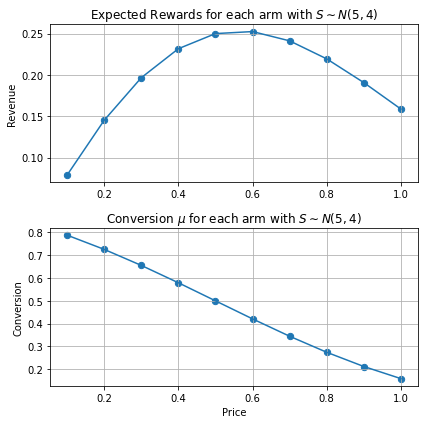

In [802]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title(r'Expected Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title(r'Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

2alpha^2 = optimal_alpha = 0.25^2

In [803]:
np.random.seed(2)
N_SIMULATIONS = 50
T = 10000

eps = 1e-2  # probability of exploration
alpha = 0.25**2/2

In [804]:
p_min = 0.1
p_max = 1
K = 10
dist_mean = 2
dist_std = 3

dist_mean = .5
dist_std = 0.5
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [805]:
def simulate_agent(T, K, dist, p_min, p_max, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    env = PricingBernoulliBanditEnv(num_arms=K, dist=dist, p_min=p_min, p_max=p_max)
    # print(env.max_reward)
    # print(env.mus.round(3))
    # print(env.mus * env.action_to_price)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    for _ in range(T):
        # print('choosing action')
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        # print('step', observation, reward, done, info)
        reward_history.append(reward)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(env.max_reward - reward_history)
    return rng_seed, name, regret

In [806]:
lr_models = [
    SimpleLinearRegressor(0, 0),
    SimpleLinearRegressor(0, 0, x_transform=np.log),
    SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1),
    SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x),
]
MeanAA_agg_alg = SimpleMeanAggregatingAlgorithm(lr_models)
hedge_agg_alg = Hedge(lr_models)
adahedge_agg_alg = AdaHedge(lr_models)
multw_agg_alg = MultiplicativeWeights(lr_models, eta=0.5)

with_mean_models = lr_models + [TargetEncodingModel()]
h_mean_agg = Hedge(with_mean_models)
ah_mean_agg = AdaHedge(with_mean_models)
mw_mean_agg = MultiplicativeWeights(with_mean_models, eta=0.5)

agent_funcs = [
#     (f"EpsilonGreedy {eps=}", lambda env: EpsilonGreedyAgent(eps=eps, num_arms=env.action_space.n)),
    ("UCB1", lambda env: UCB1Agent(alpha=alpha, num_arms=env.action_space.n, reward_normalization=1)),
    ("MeanAA", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=MeanAA_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Hedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=hedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("AdaHedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=adahedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Multiplicative Weights", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=multw_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Hedge with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=h_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
    ("AdaHedge with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=ah_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Multiplicative Weights with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=mw_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [807]:
# np.random.seed(1)
# # just to check if it works
# for n_simulation, agent_tuple in tqdm(combinations):
#     if agent_tuple[0] != "AdaHedge with mean":
#         continue
#     simulate_agent(T, K, dist, p_min, p_max, agent_tuple, n_simulation)

In [808]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(T, K, dist, p_min, p_max, agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/400 [00:00<?, ?it/s]

In [809]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [810]:
results_df.head()

,simulation,algorithm,regret
0,0,UCB1,"[0.1724441743365382, 0.28488834867307644, 0.33..."
1,0,MeanAA,"[0.1724441743365382, 0.2448883486730764, 0.401..."
2,0,Hedge,"[0.1724441743365382, 0.2448883486730764, 0.401..."
3,0,AdaHedge,"[0.1724441743365382, 0.2448883486730764, 0.401..."
4,0,Multiplicative Weights,"[0.1724441743365382, 0.2448883486730764, 0.401..."


In [811]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

In [812]:
agents = ['UCB1', 'MeanAA', 'Hedge', 'AdaHedge', 'Multiplicative Weights']

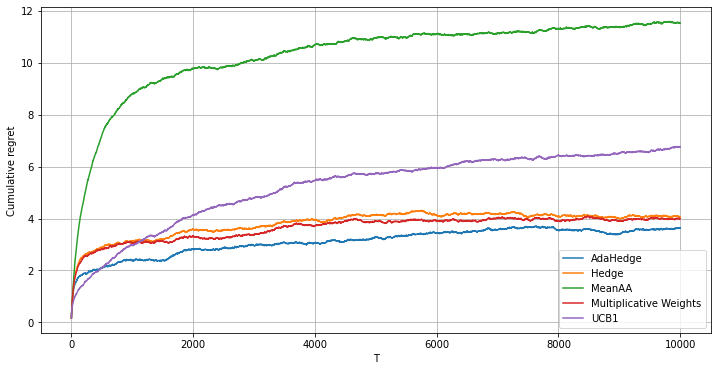

In [813]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    if name not in agents:
        continue
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [814]:
agents = ['Hedge', 'AdaHedge', 'Multiplicative Weights', "AdaHedge with mean"]
relative_regrets = {}

ucb1_regret_cumsum = np.mean(agent_to_regret['UCB1'], axis=0)
for agent_name in agents:
    regret_cumsum = np.mean(agent_to_regret[agent_name], axis=0)
    relative_regret = regret_cumsum/ucb1_regret_cumsum

    # removing the first observations for numerical stability
    relative_regret = relative_regret[100:]
    
    relative_regrets[agent_name] = relative_regret

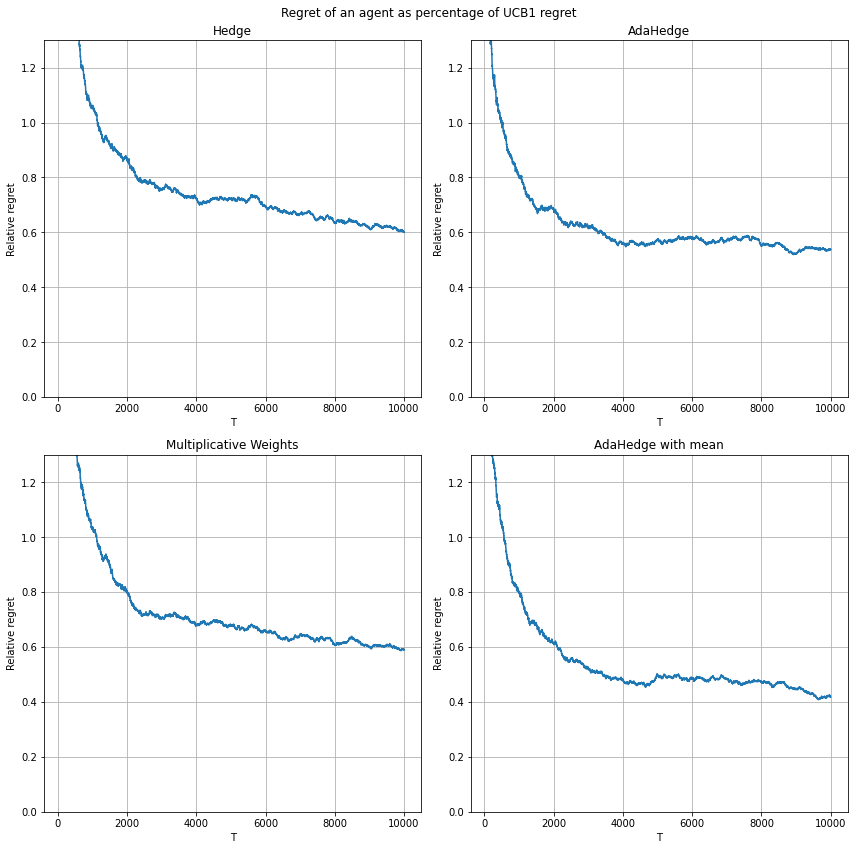

In [815]:
fig,axs=plt.subplots(figsize=(12, 12))
fig.suptitle(f'Regret of an agent as percentage of UCB1 regret')

for i, agent_name in enumerate(agents):
    plt.subplot(2, 2, i+1)
    ts = np.arange(100, T)
    plt.plot(ts, relative_regrets[agent_name])
    plt.xlabel('T')
    plt.ylabel('Relative regret')
    plt.title(agent_name)
    plt.grid()
    plt.ylim(0, 1.3);
fig.tight_layout()

Aggregating algorithms significantly outperform UCB1

### Compare the algorithms

In [836]:
# quantiles
q1 = 0.1
q2 = 1 - q1

In [837]:
agents = [
    'UCB1', 'MeanAA',
    'Hedge', 'AdaHedge', 'Multiplicative Weights',
    'Hedge with mean', 'AdaHedge with mean', 'Multiplicative Weights with mean']

In [838]:
q1_col = f'quantile {100*q1}%'
q2_col = f'quantile {100*q2}%'

In [839]:
quantile_df = pd.DataFrame()
for name in agents:
    regret = agent_to_regret[name]
    quantiles = np.quantile(regret, [q1, q2], axis=0).T
    mean = np.mean(regret, axis=0)
    qqm = np.hstack([np.quantile(regret, [q1, q2], axis=0).T, np.mean(regret, axis=0).reshape(-1, 1)])
    qqm = pd.DataFrame(qqm, columns=[q1_col, q2_col, 'mean'])
    qqm['agent'] = name
    qqm['T'] = qqm.index
    quantile_df = pd.concat([quantile_df, qqm])

In [840]:
quantile_df[quantile_df['T'] == quantile_df['T'].max()]

,quantile 10.0%,quantile 90.0%,mean,agent,T
9999,2.519443,11.816843,6.763963,UCB1,9999
9999,7.199843,15.309443,11.508723,MeanAA,9999
9999,-0.271057,8.306343,4.066923,Hedge,9999
9999,0.350543,6.958043,3.640163,AdaHedge,9999
9999,-0.351957,8.403643,3.996163,Multiplicative Weights,9999
9999,-0.610357,7.788543,3.436663,Hedge with mean,9999
9999,-0.491557,6.305543,2.829203,AdaHedge with mean,9999
9999,0.247743,7.552843,3.591443,Multiplicative Weights with mean,9999


simple mean aggregation (`MeanAA`) is much worse than the other aggregating algorithms

however, there is little to no difference between the aggregating algorithms performance

#### aggregating algorithms, MeanAA and UCB

In [841]:
agents = ['UCB1', 'MeanAA', 'AdaHedge']

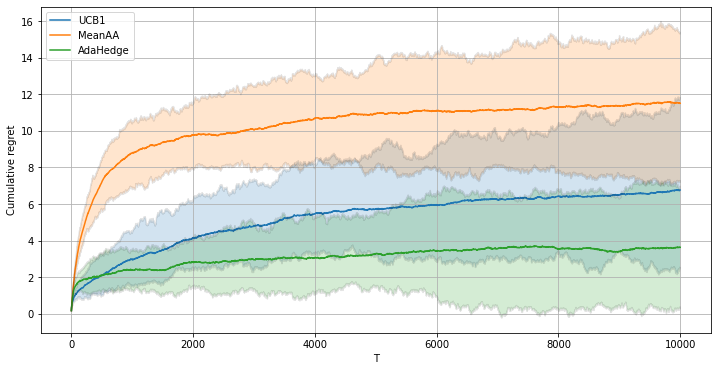

In [842]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for agent in agents:
    agent_df = quantile_df[quantile_df['agent'] == agent]
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    plt.fill_between(x=ts, y1=agent_df[q1_col], y2=agent_df[q2_col], alpha=0.2)
    sns.lineplot(x='T', y=q1_col, data=agent_df, color='black', alpha=0.1)
    sns.lineplot(x='T', y=q2_col, data=agent_df, color='black', alpha=0.1)

plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

AdaHedge is much better than MeanAA

UCB is slightly better than MeanAA

#### aggregating algorithms only

In [843]:
agents = ['Hedge', 'AdaHedge', 'Multiplicative Weights']

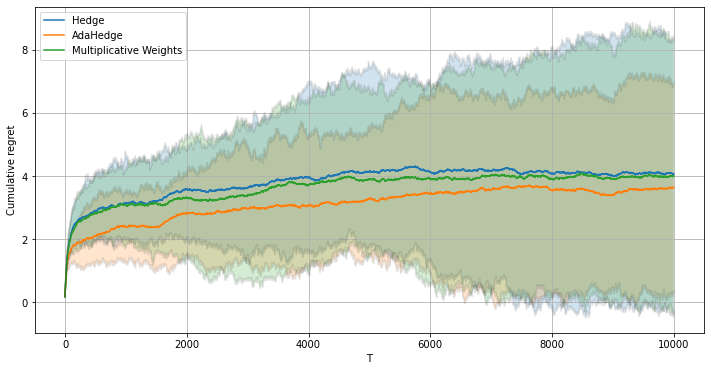

In [844]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for agent in agents:
    agent_df = quantile_df[quantile_df['agent'] == agent]
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    plt.fill_between(x=ts, y1=agent_df[q1_col], y2=agent_df[q2_col], alpha=0.2)
    sns.lineplot(x='T', y=q1_col, data=agent_df, color='black', alpha=0.1)
    sns.lineplot(x='T', y=q2_col, data=agent_df, color='black', alpha=0.1)

plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

seems like there is not noticeable difference between the aggregating algorithms on simulated data

#### aggregating algorithms, with or w/o mean estimation

In [845]:
# agents = ['AdaHedge', 'AdaHedge with mean']
agents = ['Hedge', 'AdaHedge', 'Multiplicative Weights']

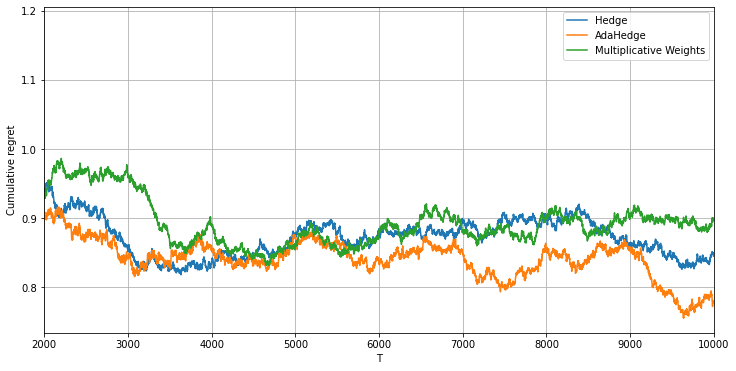

In [854]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for agent in agents:
    agent_df = quantile_df[quantile_df['agent'] == agent]
    mean_df = quantile_df[quantile_df['agent'] == f'{agent} with mean']
    sns.lineplot(x=agent_df['T'], y=mean_df['mean']/agent_df['mean'], label=agent)
#     plt.fill_between(x=ts, y1=mean_df[q1_col]/agent_df[q1_col], y2=mean_df[q2_col]/agent_df[q2_col], alpha=0.2)
#     sns.lineplot(x='T', y=q1_col, data=agent_df, color='black', alpha=0.1)
#     sns.lineplot(x='T', y=q2_col, data=agent_df, color='black', alpha=0.1)

plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.xlim(2000, T)
plt.grid();

## Running agents on avocado data

In [712]:
import os
from bandits.pricing.bandits import get_avocado_df, PricingAvocadoBanditEnv

In [75]:
base_dir = '../data/avocado/'
os.listdir(base_dir)
avocado_path = os.path.join(base_dir, 'avocado.csv')

### Test

In [101]:
avocado_df = get_avocado_df(avocado_path)
K = 10
region = 'DallasFtWorth'
start_date = pd.to_datetime('2018-01-01')
T = 5000
N_SIMULATIONS = 30

In [102]:
def simulate_agent(T, K, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    env = PricingAvocadoBanditEnv(num_arms=K, avocado_df=avocado_df, region=region, start_date=start_date)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    action_history = []
    for _ in range(T):
        # print('choosing action')
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        # print('step', observation, reward, done, info)
        reward_history.append(reward)
        action_history.append(action)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(env.max_reward - reward_history)
    return rng_seed, name, regret, env, agent, reward_history, action_history

In [103]:
lr_models = [
    SimpleLinearRegressor(0, 0),
    SimpleLinearRegressor(0, 0, x_transform=np.log),
    SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1),
    SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x),
]
MeanAA_agg_alg = SimpleMeanAggregatingAlgorithm(lr_models)
hedge_agg_alg = Hedge(lr_models)
adahedge_agg_alg = AdaHedge(lr_models)
multw_agg_alg = MultiplicativeWeights(lr_models, eta=0.5)

agent_funcs = [
#     ("UCB1", lambda env: UCB1Agent(alpha=alpha, num_arms=env.action_space.n, reward_normalization=2*p_max)),
#     ("SLRAgent", lambda env: SLRAgent(alpha=alpha, action_to_price=env.action_to_price)),
    ("MeanAA", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=MeanAA_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Hedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=hedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
#     ("AdaHedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=adahedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
#     ("Multiplicative Weights", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=multw_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [104]:
np.random.seed(1)
# just to check if it works
for n_simulation, agent_tuple in tqdm(combinations):
    rng_seed, name, regret, env, agent, reward_history, action_history = simulate_agent(T, K, agent_tuple, n_simulation)
    break

  0%|          | 0/60 [00:00<?, ?it/s]

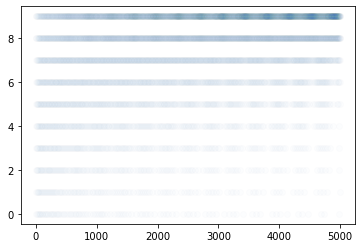

In [97]:
plt.scatter(np.arange(len(action_history)), action_history, alpha=0.01);

### Simulate

In [106]:
avocado_df = get_avocado_df(avocado_path)
K = 10
region = 'DallasFtWorth'
start_date = pd.to_datetime('2018-01-01')
T = 5000
N_SIMULATIONS = 30

In [107]:
def simulate_agent(T, K, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    env = PricingAvocadoBanditEnv(num_arms=K, avocado_df=avocado_df, region=region, start_date=start_date)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    for _ in range(T):
        # print('choosing action')
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        # print('step', observation, reward, done, info)
        reward_history.append(reward)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(env.max_reward - reward_history)
    return rng_seed, name, regret

In [108]:
lr_models = [
    SimpleLinearRegressor(0, 0),
    SimpleLinearRegressor(0, 0, x_transform=np.log),
    SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1),
    SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x),
]
MeanAA_agg_alg = SimpleMeanAggregatingAlgorithm(lr_models)
hedge_agg_alg = Hedge(lr_models)
adahedge_agg_alg = AdaHedge(lr_models)
multw_agg_alg = MultiplicativeWeights(lr_models, eta=0.5)

agent_funcs = [
#     ("UCB1", lambda env: UCB1Agent(alpha=alpha, num_arms=env.action_space.n, reward_normalization=2*p_max)),
#     ("SLRAgent", lambda env: SLRAgent(alpha=alpha, action_to_price=env.action_to_price)),
    ("MeanAA", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=MeanAA_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Hedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=hedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
#     ("AdaHedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=adahedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
#     ("Multiplicative Weights", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=multw_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [109]:
# np.random.seed(1)
# # just to check if it works
# for n_simulation, agent_tuple in tqdm(combinations):
#     simulate_agent(T, K, agent_tuple, n_simulation)

In [110]:
n_jobs = 4
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(T, K, agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/60 [00:00<?, ?it/s]

In [111]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [112]:
results_df.head()

,simulation,algorithm,regret
0,0,Gunaev,"[0.6891916572184216, 1.0805980594386784, 1.499..."
1,0,Hedge,"[0.6891916572184216, 1.0805980594386784, 1.499..."
2,1,Gunaev,"[0.8184686237197933, 1.468428958942794, 2.1313..."
3,1,Hedge,"[0.8184686237197933, 1.468428958942794, 2.1313..."
4,2,Gunaev,"[0.6787864890902603, 1.0493825550541946, 1.448..."


In [121]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

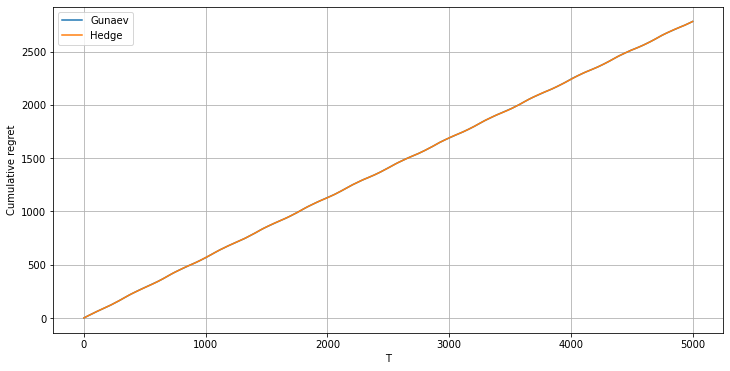

In [122]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [123]:
# quantiles
q1 = 0.025
q2 = 1 - q1

In [124]:
agents = ['MeanAA', 'Hedge']

In [125]:
quantile_df = pd.DataFrame()
for name in agents:
    regret = agent_to_regret[name]
    quantiles = np.quantile(regret, [q1, q2], axis=0).T
    mean = np.mean(regret, axis=0)
    qqm = np.hstack([np.quantile(regret, [q1, q2], axis=0).T, np.mean(regret, axis=0).reshape(-1, 1)])
    qqm = pd.DataFrame(qqm, columns=[f'quantile {100*q1}%', f'quantile {100*q2}%', 'mean'])
    qqm['agent'] = name
    qqm['T'] = qqm.index
    quantile_df = pd.concat([quantile_df, qqm])

In [126]:
quantile_df[quantile_df['T'] == 999]

,quantile 2.5%,quantile 97.5%,mean,agent,T
999,413.617422,711.620791,565.892418,Gunaev,999
999,413.715270,711.590126,565.913119,Hedge,999


takes too much time now, maybe I could optimize it by pre-predicting all possible combinations of price/date beforehand